In [ ]:
import numpy as np
import pandas as pd
from math import sqrt

from matplotlib import pyplot
from pandas import read_csv

from pandas import DataFrame
from pandas import concat

import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter


from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pywt
np.random.seed(2020)
from keras import regularizers, optimizers
from keras.models import Sequential, load_model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, LSTM, Bidirectional, BatchNormalization
from keras.layers.core import Dense, Activation
from keras.regularizers import l1_l2, l2
from numpy import array
import warnings

import matplotlib.pyplot as plt
from keras import optimizers

from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import plotly.graph_objs as go
import os
import tensorflow as tf
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.random.set_seed(1)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  #n_vars = 1 if type(data) is list else data.shape[1]
  df = DataFrame(data)
  cols, names = list(), list()
# input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var(t-%d)' % (i))] #for j in range(n_vars)]
# forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var(t)')] #for j in range(n_vars)]
    else:
      names += [('var(t+%d)' % (i))] #for j in range(n_vars)]
# put it all together
  agg = concat(cols, axis=1)
  agg.columns = names
# drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg

In [ ]:
df = pd.read_excel('/content/gdrive/MyDrive/res_data.xlsx',index_col='Date')

In [ ]:
df

,Outflow,Level,Inflow,Rainfall,"Outflow,m3","Inflow,m3"
Date,,,,,,
2000-01-01,37.731481,127.41,29.513889,0.00,3260000,2550000
2000-01-02,23.611111,127.41,23.611111,0.00,2040000,2040000
2000-01-03,40.162037,127.39,23.726852,0.00,3470000,2050000
2000-01-04,14.930556,127.40,23.148148,0.00,1290000,2000000
2000-01-05,24.074074,127.39,15.856481,0.00,2080000,1370000
...,...,...,...,...,...,...
2019-12-27,28.703704,128.85,19.791667,3.61,2480000,1710000
2019-12-28,28.472222,128.83,10.648148,0.00,2460000,920000
2019-12-29,28.703704,128.81,10.879630,0.00,2480000,940000


In [ ]:
cols = list(df)[:4]
data = df[cols].astype(float)

In [ ]:
data

,Outflow,Level,Inflow,Rainfall
Date,,,,
2000-01-01,37.731481,127.41,29.513889,0.00
2000-01-02,23.611111,127.41,23.611111,0.00
2000-01-03,40.162037,127.39,23.726852,0.00
2000-01-04,14.930556,127.40,23.148148,0.00
2000-01-05,24.074074,127.39,15.856481,0.00
...,...,...,...,...
2019-12-27,28.703704,128.85,19.791667,3.61
2019-12-28,28.472222,128.83,10.648148,0.00
2019-12-29,28.703704,128.81,10.879630,0.00


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data= scaler.fit_transform(data)

In [ ]:
scaled_data

array([[0.00657656, 0.69470405, 0.00482124, 0.        ],
       [0.00411539, 0.69470405, 0.00385699, 0.        ],
       [0.0070002 , 0.69314642, 0.0038759 , 0.        ],
       ...,
       [0.00500303, 0.80373832, 0.00177724, 0.        ],
       [0.00748437, 0.80062305, 0.00122894, 0.        ],
       [0.00746419, 0.79750779, 0.00121004, 0.        ]])

In [ ]:
O,L,I,R =scaled_data.T

In [ ]:
Os = series_to_supervised(O,4,2)
Ls = series_to_supervised(L,2,0)
Is= series_to_supervised(I,2,0)
Rs = series_to_supervised(R,1,0)


In [ ]:
dfs=[Os,Ls,Is,Rs]
Input=pd.concat(dfs,axis=1,keys=range(1,len(dfs)+1))
Input.columns = Input.columns.map('{0[1]}{0[0]}'.format)
Input = Input.iloc[3-0:]
Input = Input.drop(Input.index[-3:])



In [ ]:

Input

,var(t-4)1,var(t-3)1,var(t-2)1,var(t-1)1,var(t)1,var(t+1)1,var(t-2)2,var(t-1)2,var(t-2)3,var(t-1)3,var(t-1)4
4,0.006577,0.004115,0.007000,0.002602,0.004196,0.008473,0.693146,0.693925,0.003876,0.003781,0.000000
5,0.004115,0.007000,0.002602,0.004196,0.008473,0.007948,0.693925,0.693146,0.003781,0.002590,0.000000
6,0.007000,0.002602,0.004196,0.008473,0.007948,0.007807,0.693146,0.690810,0.002590,0.003933,0.000000
7,0.002602,0.004196,0.008473,0.007948,0.007807,0.007767,0.690810,0.688474,0.003933,0.003441,0.000000
8,0.004196,0.008473,0.007948,0.007807,0.007767,0.006032,0.688474,0.686137,0.003441,0.003328,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
7297,0.005003,0.000000,0.002118,0.002986,0.002986,0.002986,0.811526,0.811526,0.001985,0.002798,0.000000
7298,0.000000,0.002118,0.002986,0.002986,0.002986,0.005003,0.811526,0.810748,0.002798,0.001323,0.000000
7299,0.002118,0.002986,0.002986,0.002986,0.005003,0.005003,0.810748,0.809190,0.001323,0.000000,0.003351
7300,0.002986,0.002986,0.002986,0.005003,0.005003,0.004963,0.809190,0.807632,0.000000,0.001777,0.024400


In [ ]:
y=Input[Input.columns[Input.columns.isin(['var(t+1)1'])]]

In [ ]:
y

,var(t+1)1
4,0.008473
5,0.007948
6,0.007807
7,0.007767
8,0.006032
...,...
7297,0.002986
7298,0.005003
7299,0.005003
7300,0.004963


In [ ]:
X=Input.drop(['var(t+1)1','var(t)1'],axis=1)


In [ ]:
X

,var(t-4)1,var(t-3)1,var(t-2)1,var(t-1)1,var(t-2)2,var(t-1)2,var(t-2)3,var(t-1)3,var(t-1)4
4,0.006577,0.004115,0.007000,0.002602,0.693146,0.693925,0.003876,0.003781,0.000000
5,0.004115,0.007000,0.002602,0.004196,0.693925,0.693146,0.003781,0.002590,0.000000
6,0.007000,0.002602,0.004196,0.008473,0.693146,0.690810,0.002590,0.003933,0.000000
7,0.002602,0.004196,0.008473,0.007948,0.690810,0.688474,0.003933,0.003441,0.000000
8,0.004196,0.008473,0.007948,0.007807,0.688474,0.686137,0.003441,0.003328,0.000000
...,...,...,...,...,...,...,...,...,...
7297,0.005003,0.000000,0.002118,0.002986,0.811526,0.811526,0.001985,0.002798,0.000000
7298,0.000000,0.002118,0.002986,0.002986,0.811526,0.810748,0.002798,0.001323,0.000000
7299,0.002118,0.002986,0.002986,0.002986,0.810748,0.809190,0.001323,0.000000,0.003351
7300,0.002986,0.002986,0.002986,0.005003,0.809190,0.807632,0.000000,0.001777,0.024400


In [ ]:
x_train=X[:4378]
x_val=X[4378:5472]
x_test=X[5472:]
y_train=y[:4378]
y_val=y[4378:5472]
y_test=y[5472:]

In [ ]:
x_train

,var(t-4)1,var(t-3)1,var(t-2)1,var(t-1)1,var(t-2)2,var(t-1)2,var(t-2)3,var(t-1)3,var(t-1)4
4,0.006577,0.004115,0.007000,0.002602,0.693146,0.693925,0.003876,0.003781,0.0
5,0.004115,0.007000,0.002602,0.004196,0.693925,0.693146,0.003781,0.002590,0.0
6,0.007000,0.002602,0.004196,0.008473,0.693146,0.690810,0.002590,0.003933,0.0
7,0.002602,0.004196,0.008473,0.007948,0.690810,0.688474,0.003933,0.003441,0.0
8,0.004196,0.008473,0.007948,0.007807,0.688474,0.686137,0.003441,0.003328,0.0
...,...,...,...,...,...,...,...,...,...
4377,0.000767,0.001937,0.001937,0.000000,0.657321,0.657321,0.001815,0.000000,0.0
4378,0.001937,0.001937,0.000000,0.000000,0.657321,0.658100,0.000000,0.001286,0.0
4379,0.001937,0.000000,0.000000,0.000000,0.658100,0.658100,0.001286,0.000000,0.0
4380,0.000000,0.000000,0.000000,0.000000,0.658100,0.658879,0.000000,0.001286,0.0


In [ ]:
x_val

,var(t-4)1,var(t-3)1,var(t-2)1,var(t-1)1,var(t-2)2,var(t-1)2,var(t-2)3,var(t-1)3,var(t-1)4
4382,0.000000,0.000000,0.000000,0.000000,0.658879,0.658879,0.000000,0.000000,0.000000
4383,0.000000,0.000000,0.000000,0.000000,0.658879,0.658879,0.000000,0.000000,0.000000
4384,0.000000,0.000000,0.000000,0.000000,0.658879,0.660436,0.000000,0.002571,0.018213
4385,0.000000,0.000000,0.000000,0.000000,0.660436,0.662773,0.002571,0.003857,0.010917
4386,0.000000,0.000000,0.000000,0.000000,0.662773,0.662773,0.003857,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
5471,0.001251,0.001251,0.001251,0.001251,0.403427,0.404206,0.001172,0.001928,0.000000
5472,0.001251,0.001251,0.001251,0.001251,0.404206,0.404206,0.001928,0.001172,0.000000
5473,0.001251,0.001251,0.001251,0.001251,0.404206,0.404206,0.001172,0.001172,0.000000
5474,0.001251,0.001251,0.001251,0.001251,0.404206,0.404206,0.001172,0.001172,0.000000


In [ ]:
x_test

,var(t-4)1,var(t-3)1,var(t-2)1,var(t-1)1,var(t-2)2,var(t-1)2,var(t-2)3,var(t-1)3,var(t-1)4
5476,0.001251,0.001251,0.001251,0.010006,0.404206,0.396417,0.001172,0.001872,0.000000
5477,0.001251,0.001251,0.010006,0.009966,0.396417,0.389408,0.001872,0.002685,0.000000
5478,0.001251,0.010006,0.009966,0.009966,0.389408,0.381620,0.002685,0.002061,0.000000
5479,0.010006,0.009966,0.009966,0.001271,0.381620,0.380841,0.002061,0.000473,0.000000
5480,0.009966,0.009966,0.001271,0.001271,0.380841,0.380841,0.000473,0.001191,0.000000
...,...,...,...,...,...,...,...,...,...
7297,0.005003,0.000000,0.002118,0.002986,0.811526,0.811526,0.001985,0.002798,0.000000
7298,0.000000,0.002118,0.002986,0.002986,0.811526,0.810748,0.002798,0.001323,0.000000
7299,0.002118,0.002986,0.002986,0.002986,0.810748,0.809190,0.001323,0.000000,0.003351
7300,0.002986,0.002986,0.002986,0.005003,0.809190,0.807632,0.000000,0.001777,0.024400


In [ ]:
#convert into array
x_train=x_train.values
y_train=y_train.values
x_test=x_test.values
y_test=y_test.values
x_val=x_val.values
y_val=y_val.values


In [ ]:

x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
# y_train = y_train.reshape((y_train.shape[0], 1,y_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1,x_val.shape[1]))
# y_val = y_val.reshape((x_val.shape[0], 1,x_val.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1,x_test.shape[1]))
# y_test = y_train.reshape((y_train.shape[0], 1,y_train.shape[1]))



In [ ]:
x_train.shape,x_test.shape,x_val.shape

((4378, 1, 9), (1826, 1, 9), (1094, 1, 9))

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(x_train.shape[1],x_train.shape[2]), return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(64, activation='relu', return_sequences=False))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer='adam')
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 50)             12000     
                                                                 
 dropout (Dropout)           (None, 1, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 41,505
Trainable params: 41,505
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_history = model_lstm.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=110, verbose=2,batch_size=128)

Epoch 1/110
35/35 - 4s - loss: 0.0019 - val_loss: 0.0010 - 4s/epoch - 128ms/step
Epoch 2/110
35/35 - 0s - loss: 0.0017 - val_loss: 9.1234e-04 - 344ms/epoch - 10ms/step
Epoch 3/110
35/35 - 0s - loss: 0.0013 - val_loss: 5.2561e-04 - 436ms/epoch - 12ms/step
Epoch 4/110
35/35 - 0s - loss: 9.4750e-04 - val_loss: 4.3783e-04 - 447ms/epoch - 13ms/step
Epoch 5/110
35/35 - 0s - loss: 8.1428e-04 - val_loss: 4.1624e-04 - 451ms/epoch - 13ms/step
Epoch 6/110
35/35 - 0s - loss: 7.8418e-04 - val_loss: 3.7939e-04 - 414ms/epoch - 12ms/step
Epoch 7/110
35/35 - 1s - loss: 7.0190e-04 - val_loss: 3.8547e-04 - 505ms/epoch - 14ms/step
Epoch 8/110
35/35 - 1s - loss: 6.5049e-04 - val_loss: 3.6615e-04 - 677ms/epoch - 19ms/step
Epoch 9/110
35/35 - 1s - loss: 6.7393e-04 - val_loss: 3.6443e-04 - 625ms/epoch - 18ms/step
Epoch 10/110
35/35 - 1s - loss: 6.3366e-04 - val_loss: 3.8177e-04 - 610ms/epoch - 17ms/step
Epoch 11/110
35/35 - 1s - loss: 6.3292e-04 - val_loss: 3.5758e-04 - 559ms/epoch - 16ms/step
Epoch 12/110
35

In [ ]:
hist_df = pd.DataFrame( lstm_history.history )
hist_df

,loss,val_loss
0,0.001949,0.001023
1,0.001686,0.000912
2,0.001297,0.000526
3,0.000947,0.000438
4,0.000814,0.000416
...,...,...
105,0.000445,0.000431
106,0.000485,0.000428
107,0.000461,0.000429
108,0.000468,0.000471


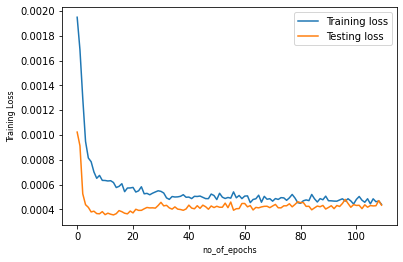

In [ ]:
plt.plot(lstm_history.history['loss'],label='Training loss' )
plt.plot(lstm_history.history['val_loss'], label='Testing loss')
plt.xlabel('no_of_epochs', fontsize=8 )
plt.ylabel('Training Loss', fontsize=8 )
plt.legend()

In [ ]:
train_yp = model_lstm.predict(x_train)
val_yp = model_lstm.predict(x_val)
test_yp = model_lstm.predict(x_test)



58/58 [==============================] - 0s 3ms/step


In [ ]:
train_yp.shape,test_yp.shape,val_yp.shape

((4378, 1), (1826, 1), (1094, 1))

In [ ]:
y_train.shape

(4378, 1)

In [ ]:
#reshape into the origional form (2-D)
x_train = x_train.reshape((x_train.shape[0],x_train.shape[2]))
x_val = x_val.reshape((x_val.shape[0],x_val.shape[2]))
x_test= x_test.reshape((x_test.shape[0],x_test.shape[2]))

In [ ]:
y_train.shape,x_train.shape,

((4378, 1), (4378, 9))

In [ ]:
#inverse_transform
#1)x_train
inv_x_train=pd.concat([pd.DataFrame(train_yp), pd.DataFrame(x_train[:, :3])], axis=1)
rev_trans=scaler.inverse_transform(inv_x_train)
y_train_prediction=rev_trans[:,0]

#y_train
inv_y_train=pd.concat([pd.DataFrame(y_train), pd.DataFrame(x_train[:, :3])], axis=1)
rev_trans=scaler.inverse_transform(inv_y_train)
y_train_Observed=rev_trans[:,0]

#1)x_val
inv_x_val=pd.concat([pd.DataFrame(val_yp), pd.DataFrame(x_val[:, :3])], axis=1)
rev_trans=scaler.inverse_transform(inv_x_val)
y_val_prediction=rev_trans[:,0]

#y_val
inv_y_val=pd.concat([pd.DataFrame(y_val), pd.DataFrame(x_val[:, :3])], axis=1)
rev_trans=scaler.inverse_transform(inv_y_val)
y_val_Observed=rev_trans[:,0]


#x_test
inv_x_test=pd.concat([pd.DataFrame(test_yp), pd.DataFrame(x_train[:, :3])], axis=1)
rev_trans=scaler.inverse_transform(inv_x_test)
y_test_prediction=rev_trans[:,0]

#y_test
inv_y_test=pd.concat([pd.DataFrame(y_test), pd.DataFrame(x_train[:, :3])], axis=1)
rev_trans=scaler.inverse_transform(inv_y_test)
y_test_Observed=rev_trans[:,0]

In [ ]:
# y_train_pre=np.array(y_train_prediction)
# y_train_rev=np.array(y_train_Observed)
l=np.array([y_train_prediction,y_train_Observed])
dataset_train=pd.DataFrame(l)
dataset_train=dataset_train.transpose()
dataset_train.columns = ['Predicted', 'Observed']

<AxesSubplot:>

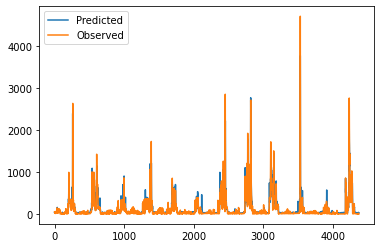

In [ ]:

dataset_train[['Predicted', 'Observed']].plot()

<ipython-input-43-e20595a744fe>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_lim, y_lim, 'k-', color = 'black', label = '1:1 line')


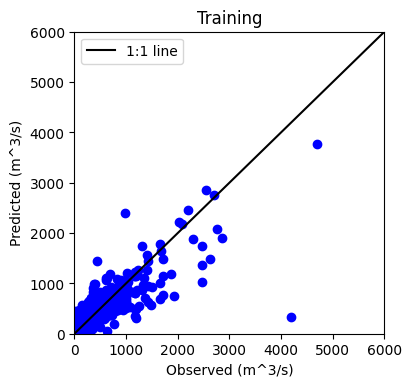

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4), dpi=100)
plt.scatter(dataset_train.Observed,dataset_train.Predicted, color='b')
y_lim = plt.ylim([0, 6000])
x_lim = plt.ylim([0, 6000])
plt.plot(x_lim, y_lim, 'k-', color = 'black', label = '1:1 line')
plt.ylim(y_lim)
plt.xlim(x_lim)
plt.title('Training')
plt.xlabel("Observed (m^3/s)")
plt.ylabel("Predicted (m^3/s)")
plt.legend()

Text(0, 0.5, 'Reservoir outflows (m^3/s)')

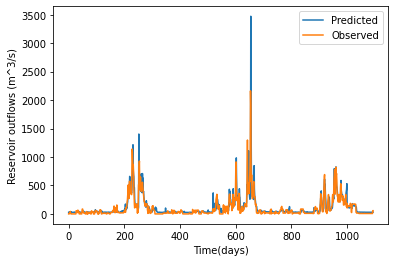

In [ ]:
l=np.array([y_val_prediction,y_val_Observed])
dataset_val=pd.DataFrame(l)
dataset_val=dataset_val.transpose()
dataset_val.columns = ['Predicted', 'Observed']
dataset_val[['Predicted', 'Observed']].plot()
plt.xlabel("Time(days)")
plt.ylabel("Reservoir outflows (m^3/s)")

In [ ]:
#to save as csv file
# dataset.to_csv('/content/gdrive/MyDrive/2day_leadtime_results/shiv_1day_train_Observed_prediction_gru.csv')

In [ ]:
!pip install hydroeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from hydroeval import evaluator, nse
from sklearn.metrics import mean_squared_error

NSE_train = evaluator(nse,y_train_prediction , y_train_Observed )
RMSE_train = sqrt(mean_squared_error(y_train_Observed,y_train_prediction))
print(NSE_train, RMSE_train)


NSE_val = evaluator(nse,y_val_prediction , y_val_Observed )
RMSE_val = sqrt(mean_squared_error(y_val_Observed,y_val_prediction))
print(NSE_val, RMSE_val)

[0.7917202] 116.10780885665767
[0.59829432] 119.49245474762574


<AxesSubplot:>

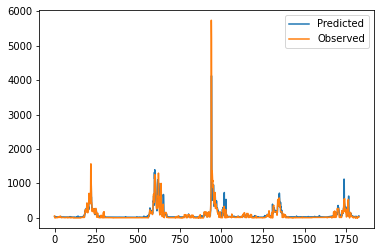

In [ ]:
#test
# y_test_prediction=np.array(y_test_prediction)
# y_test_Observed=np.array(y_test_Observed)
l1 = np.array([y_test_prediction,y_test_Observed])
dataset_test=pd.DataFrame(l1)
dataset_test=dataset_test.transpose()
dataset_test.columns = ['Predicted', 'Observed']
dataset_test[['Predicted','Observed']].plot()

<ipython-input-49-638b5cbc6621>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_lim, y_lim, 'k-', color = 'black', label = '1:1 line')


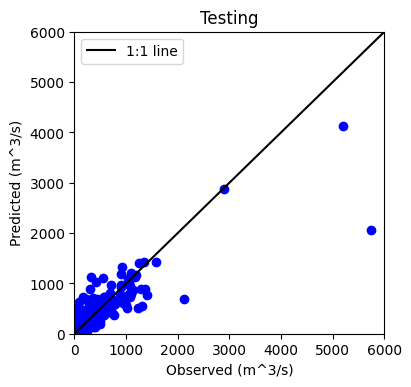

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4), dpi=100)
plt.scatter(dataset_test.Observed,dataset_test.Predicted, color='b')
y_lim = plt.ylim([0, 6000])
x_lim = plt.ylim([0, 6000])
plt.plot(x_lim, y_lim, 'k-', color = 'black', label = '1:1 line')
plt.ylim(y_lim)
plt.xlim(x_lim)
plt.title('Testing')
plt.xlabel("Observed (m^3/s)")
plt.ylabel("Predicted (m^3/s)")
plt.legend()

In [ ]:
y_test_prediction

array([38.43241505, 43.79996917, 45.39554842, ...,         nan,
               nan,         nan])

In [ ]:
test_result=np.array([y_test_prediction,y_test_Observed])
df_test=pd.DataFrame(test_result)
df_test=df_test.transpose()
df_test.columns = ['y_test_prediction','y_test_Observed']
df_test.head(1825)
df_test=df_test.drop(df_test.index[1825:])
df_test

,y_test_prediction,y_test_Observed
0,38.432415,57.175926
1,43.799969,7.291667
2,45.395548,7.291667
3,34.080703,0.000000
4,31.708365,7.291667
...,...,...
1820,37.786598,17.129630
1821,38.980207,17.129630
1822,37.361484,28.703704
1823,38.266932,28.703704


In [ ]:
NSE_test = evaluator(nse,y_test_prediction , y_test_Observed)
RMSE_test = sqrt(mean_squared_error(df_test.y_test_prediction, df_test.y_test_Observed))
print(NSE_test)
print(RMSE_test)

[0.7762642]
125.51759235636064


In [ ]:
 #to save as csv file
# dataset.to_csv('/content/gdrive/MyDrive/2day_leadtime_results/shiv_1day_test_Observed_prediction_gru.csv')